This notebook implements the CEFLANN stock price prediction model described in the research paper "A hybrid stock trading framework integrating technical analysis with machine learning" (Dash & Dash, 2016).

In [16]:
# Import required libraries
# To install, run "conda install -c conda-forge <package1> <package2>" in the Anaconda prompt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
from scipy import linalg
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [17]:
# Function to load NVIDIA data from exported files
def load_nvidia_data(base_dir='data'):
    """
    Parameters:
        base_dir : Base directory where data files are stored
    
    Returns:
        Dictionary containing loaded data
    """
    # Defines directory paths
    csv_dir = f'{base_dir}'
    train_dir = f'{base_dir}/npy/train'
    test_dir = f'{base_dir}/npy/test'
    
    # Loads CSV data
    technical_data = pd.read_csv(f'{csv_dir}/nvidia_technical_data.csv', index_col=0, parse_dates=True, date_format="%d/%m/%Y")
    normalized_data = pd.read_csv(f'{csv_dir}/nvidia_normalized_data.csv', index_col=0, parse_dates=True, date_format="%d/%m/%Y")
    ceflann_data = pd.read_csv(f'{csv_dir}/nvidia_ceflann_data.csv', index_col=0, parse_dates=True, date_format="%d/%m/%Y")
    
    # Loads NumPy arrays for training and testing
    X_train = np.load(f'{train_dir}/nvidia_X_train.npy')
    y_train = np.load(f'{train_dir}/nvidia_y_train.npy')
    train_dates = np.load(f'{train_dir}/nvidia_train_dates.npy', allow_pickle=True)
    train_prices = np.load(f'{train_dir}/nvidia_train_price_data.npy')
    
    # Loads main test data
    X_test = np.load(f'{test_dir}/nvidia_X_test.npy')
    y_test = np.load(f'{test_dir}/nvidia_y_test.npy')
    test_dates = np.load(f'{test_dir}/nvidia_test_dates.npy', allow_pickle=True)
    test_prices = np.load(f'{test_dir}/nvidia_price_data.npy')
    
    # Tries to load multiple test weeks if available
    test_weeks = []
    test_weeks_info = np.load(f'{base_dir}/npy/nvidia_test_weeks_info.npy', allow_pickle=True)
    
    # Loads each test week
    for i in range(len(test_weeks_info)):
        try:
            week_data = {
                'X': np.load(f'{test_dir}/nvidia_X_test_week_{i}.npy'),
                'y': np.load(f'{test_dir}/nvidia_y_test_week_{i}.npy'),
                'dates': np.load(f'{test_dir}/nvidia_test_dates_week_{i}.npy', allow_pickle=True),
                'prices': np.load(f'{test_dir}/nvidia_price_data_week_{i}.npy'),
                'info': test_weeks_info[i]
            }
            test_weeks.append(week_data)
        except Exception as e:
            print(f"Warning: Could not load test week {i}: {e}")
    
    # Loads latest info
    with open(f'{csv_dir}/nvidia_info.txt', 'r') as f:
        latest_info = f.read().split(',')
        latest_date = latest_info[0]
        latest_close = float(latest_info[1])
        test_week_length = int(latest_info[2]) if len(latest_info) > 2 else 5
        num_test_weeks = int(latest_info[3]) if len(latest_info) > 3 else 0
    
    return {
        'technical_data': technical_data,
        'normalized_data': normalized_data,
        'ceflann_data': ceflann_data,
        'X_train': X_train,
        'y_train': y_train,
        'train_dates': train_dates,
        'train_prices': train_prices,
        'X_test': X_test,
        'y_test': y_test,
        'test_dates': test_dates,
        'test_prices': test_prices,
        'test_weeks': test_weeks,
        'test_weeks_info': test_weeks_info,
        'latest_date': latest_date,
        'latest_close': latest_close,
        'test_week_length': test_week_length,
        'num_test_weeks': num_test_weeks
    }

In [18]:
# Load all NVIDIA data
nvidia_data = load_nvidia_data()

# Print summary of loaded data
print(f"Latest date: {nvidia_data['latest_date']}")
print(f"Latest NVIDIA close price: ${nvidia_data['latest_close']:.2f}")
print(f"Training data shape: X={nvidia_data['X_train'].shape}, y={nvidia_data['y_train'].shape}")
print(f"Testing data shape: X={nvidia_data['X_test'].shape}, y={nvidia_data['y_test'].shape}")
print(f"Number of test weeks: {len(nvidia_data['test_weeks'])}")

Latest date: 2025-03-14 00:00:00
Latest NVIDIA close price: $121.67
Training data shape: X=(1031, 6), y=(1031,)
Testing data shape: X=(5, 6), y=(5,)
Number of test weeks: 54


In [19]:
class CEFLANN:
    """
    The Computational Efficient Functional Link Artificial Neural Network model
    
    The implementation is based on "A hybrid stock trading framework integrating 
    technical analysis with machine learning techniques" by Dash & Dash (2016)
    """
    
    def __init__(self, expansion_order=5, regularization=0.01):
        """
        Parameters:
            expansion_order(int) : The order of expansion for the functional expansion block
            regularization(float) : Regularization parameter for the ELM learning
        """
        self.expansion_order = expansion_order
        self.regularization = regularization
        self.output_weights = None
        self.expansion_params = None
        
    def _functional_expansion(self, X):
        """
        Parameters:
            X : Input feature matrix with shape (n_samples, n_features)
            
        Returns:
            expanded_X : Expanded input pattern array
        """
        n_samples, n_features = X.shape
        
        # Number of expanded features = original features + expansion order
        n_expanded = n_features + self.expansion_order
        
        # Initializes the expanded feature matrix
        expanded_X = np.zeros((n_samples, n_expanded))
        expanded_X[:, :n_features] = X
        
        
        if self.expansion_params is None:
            # For each order i, initializes parameters a_i0 and a_ij (j is from 1 to n_features)
            self.expansion_params = []
            for i in range(self.expansion_order):
                # Initialize bias term a_i0
                a_i0 = np.random.uniform(-1, 1)
                
                # Initialize weights a_ij for each feature
                a_ij = np.random.uniform(-1, 1, size=n_features)
                
                self.expansion_params.append((a_i0, a_ij))
        
        # Applies functional expansion for each order
        for i in range(self.expansion_order):
            a_i0, a_ij = self.expansion_params[i]
            
            # Calculates weighted sum of input features
            weighted_sum = a_i0 + np.dot(X, a_ij)
            
            # Applies a tanh activation function
            expanded_X[:, n_features + i] = np.tanh(weighted_sum)
            
        return expanded_X
    
    def fit(self, X, y):
        """
        Parameters:
            X : Training feature matrix of shape (n_samples, n_features)
            y : Target values array of shape (n_samples,)
            
        Returns:
            self : Returns self
        """
        # Applies functional expansion to transform input features
        expanded_X = self._functional_expansion(X)
        
        # Adds the bias to the expanded input
        n_samples = expanded_X.shape[0]
        bias_col = np.ones((n_samples, 1))
        M = np.hstack((bias_col, expanded_X))
        
        # Uses regularized least squares (Ridge Regression) for output weights        
        n_cols = M.shape[1]
        MtM = np.dot(M.T, M)
        reg_term = self.regularization * np.eye(n_cols)
        inverse_term = np.linalg.inv(MtM + reg_term)
        MP_inverse = np.dot(inverse_term, M.T)
        
        # Calculates output weights
        self.output_weights = np.dot(MP_inverse, y)
        
        return self
    
    def predict(self, X):
        """
        Parameters:
            X : Test feature matrix of shape (n_samples, n_features)
            
        Returns:
            y_pred : Array of predicted values
        """
        # Applies functional expansion to transform input features
        expanded_X = self._functional_expansion(X)
        
        # Adds bias to expanded input
        n_samples = expanded_X.shape[0]
        bias_col = np.ones((n_samples, 1))
        M = np.hstack((bias_col, expanded_X))
        
        y_pred = np.dot(M, self.output_weights)
        
        return y_pred
    
    def evaluate(self, X, y):
        """
        Parameters:
            X : Test feature matrix array
            y : Target values array
            
        Returns:
            metrics : Dictionary containing evaluation metrics
        """
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        return {
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'rmse': np.sqrt(mse),
            'predictions': y_pred
        }
    
    # Save model parameters to a file
    def save(self, filename):
        
        if self.output_weights is None:
            raise ValueError("The model isn't trained yet")
        
        model_params = {
            'expansion_order': self.expansion_order,
            'regularization': self.regularization,
            'output_weights': self.output_weights,
            'expansion_params': self.expansion_params
        }
        
        np.save(filename, model_params)
        
    #Load model parameters from a file
    def load(self, filename):
        
        model_params = np.load(filename, allow_pickle=True).item()
        
        self.expansion_order = model_params['expansion_order']
        self.regularization = model_params['regularization']
        self.output_weights = model_params['output_weights']
        self.expansion_params = model_params['expansion_params']
        
        return self

In [20]:
# Training functions for CEFLANN model with hyperparameter selection

def train_model(X_train, y_train, expansion_order=5, regularization=0.01):
    """
        
    Parameters:
        X_train : Training features
        y_train : Training targets
        expansion_order : Order of expansion for functional expansion block
        regularization : Regularization parameter for ELM learning
    
    Returns:
        model : Trained CEFLANN model
        training_time : Time taken to train the model
    """
    model = CEFLANN(expansion_order=expansion_order, regularization=regularization)
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    return model, training_time

In [21]:
# Tunes optimal hyperparameters for the CEFLANN model
def find_best_hyperparameters(X_train, y_train, X_val, y_val, expansion_orders=[3, 5, 7], 
                              regularizations=[0.001, 0.01, 0.1, 1.0]):
    """
    Parameters:
        X_train : Training features
        y_train : Training targets
        X_val : Validation features
        y_val : Validation targets
        expansion_orders : List of expansion orders to try
        regularizations : List of regularization parameters to try
    
    Returns:
        best_params : Dictionary containing best parameters
        results : DataFrame containing all results
    """
    results = []
    
    best_mse = float('inf')
    best_params = {}
    
    for order in expansion_orders:
        for reg in regularizations:
            model, train_time = train_model(X_train, y_train, order, reg)
            
            # Evaluate on validation set
            metrics = model.evaluate(X_val, y_val)
            
            result = {
                'expansion_order': order,
                'regularization': reg,
                'train_time': train_time,
                'mse': metrics['mse'],
                'rmse': metrics['rmse'],
                'r2': metrics['r2'],
                'mae': metrics['mae']
            }
            
            results.append(result)
            
            # Update best parameters if needed
            if metrics['mse'] < best_mse:
                best_mse = metrics['mse']
                best_params = {
                    'expansion_order': order,
                    'regularization': reg
                }
    
    
    results_df = pd.DataFrame(results)
    
    return best_params, results_df

In [22]:
# Function to train and evaluate the final model
def train_final_model(X_train, y_train, X_test, y_test, params=None):
    """
    Parameters:
        X_train : Training features
        y_train : Training targets
        X_test : Test features
        y_test : Test targets
        params : Dictionary of parameters (if None, use defaults)
    
    Returns:
        model : Trained model
        metrics : Dictionary of evaluation metrics
    """
    if params is None:
        expansion_order = 5
        regularization = 0.01
    else:
        expansion_order = params.get('expansion_order', 5)
        regularization = params.get('regularization', 0.01)
    
    model, train_time = train_model(X_train, y_train, expansion_order, regularization)
    
    # Evaluate on test set
    metrics = model.evaluate(X_test, y_test)
    metrics['train_time'] = train_time
    
    return model, metrics

In [23]:
# Trading decision system based on CEFLANN predictions and the the Dash & Dash (2016) paper
# Implements signal processing and trading rules for the CEFLANN model
class TradingDecisionSystem:
    '''
    Functions:
        classify_trends():
        generate_trading_decisions():
        get_trading_decisions():
        interpret_decision():
    '''
    def __init__(self, signal_threshold=0.5):
        """
        Parameters:
            signal_threshold : Threshold to classify signals (default: 0.5)
        """
        self.signal_threshold = signal_threshold
        
    def classify_trends(self, trading_signals):
        """
        Parameters:
            trading_signals : Array of trading signals (0-1 range)
        
        Returns:
            trends : Array of trend classifications (1 for uptrend, 0 for downtrend)
        """
        # Compare with threshold to determine trend
        return np.where(trading_signals > self.signal_threshold, 1, 0)
    
    
    def get_trading_decisions(self, model_predictions, prices=None, max_holds=2):
        """
        Parameters:
            model_predictions : Array of model predictions (trading signals)
        
        Returns:
            decisions : Array of trading decisions (1: Buy, 0: Hold, -1: Sell)
            trends : Array of trend classifications
        """
        
        trends = self.classify_trends(model_predictions)
        decisions = np.zeros(len(trends), dtype=int)
        
        # First day is always BUY
        decisions[0] = 1  # BUY
        
        # For remaining days, apply trend-based rules
        for i in range(1, len(trends)):
            # Uptrend following downtrend → BUY
            if trends[i] == 1 and trends[i-1] == 0:
                decisions[i] = 1
            # Downtrend following uptrend → SELL
            elif trends[i] == 0 and trends[i-1] == 1:
                decisions[i] = -1
            # Otherwise HOLD
            else:
                decisions[i] = 0
        
        # Count decision types
        num_buys = sum(1 for d in decisions if d == 1)
        num_sells = sum(1 for d in decisions if d == -1)
        num_holds = sum(1 for d in decisions if d == 0)
        
        # Ensure at least one SELL (if there's more than one day)
        if num_sells == 0 and len(decisions) > 1:
            # Find best day for selling (lowest prediction)
            best_sell_idx = np.argmin(model_predictions[1:]) + 1  # Skip first day
            
            # Don't sell on the first day, only on subsequent days
            if decisions[best_sell_idx] != 1 or num_buys > 1:
                decisions[best_sell_idx] = -1
                if decisions[best_sell_idx] == 1:
                    num_buys -= 1
                else:
                    num_holds -= 1
                num_sells += 1
        
        # Limit HOLD decisions by converting to BUY/SELL based on signal strength
        while num_holds > max_holds:
            hold_indices = [i for i, d in enumerate(decisions) if d == 0]
            if not hold_indices:
                break
            
            # Convert most confident HOLD (furthest from threshold)
            confidence = [abs(model_predictions[i] - self.signal_threshold) for i in hold_indices]
            idx_to_change = hold_indices[np.argmax(confidence)]
            
            # Convert to BUY or SELL based on signal strength
            if model_predictions[idx_to_change] > self.signal_threshold:
                decisions[idx_to_change] = 1  # BUY
                num_buys += 1
            else:
                decisions[idx_to_change] = -1  # SELL
                num_sells += 1
            num_holds -= 1
        
        # Convert to string format
        decisions_str = [self.interpret_decision(d) for d in decisions]
        
        return decisions_str, trends
    
    def interpret_decision(self, decision):
        """
        Parameters:
            decision : Numeric decision (1: Buy, 0: Hold, -1: Sell)
        
        Returns:
            A string representation of the decision (Buy/Sell/Hold)
        """
        if decision == 1:
            return "BUY"
        elif decision == -1:
            return "SELL"
        else:
            return "HOLD"

In [24]:
# Order Generation System class, determines how much to buy or sell.
# Takes the trading signal (BUY/SELL/HOLD) from the TradingDecisionSystem class, and scales it to the signal strength.
# Outputs buy or sell orders with specific quantities (buy/sell x stock).
class OrderGenerator:
    
    def __init__(self, simulation):
        """
        Parameters:
            simulation : TradingSimulation instance
        """
        self.simulation = simulation
    
    def generate_order(self, decision, price, portfolio_value, cash, current_shares, signal_strength):
        """
        Parameters:
            decision : Trading decision (BUY, SELL, HOLD)
            price : Current stock price
            portfolio_value : Current portfolio value
            cash : Available cash
            current_shares : Current shares held
            signal_strength : Model prediction (0.0-1.0)
        
        Returns:
            order_string : Formatted order string
            order_details : Dictionary with order details
        """
        order_details = {
            'decision': decision,
            'price': price,
            'portfolio_value': portfolio_value,
            'cash': cash,
            'current_shares': current_shares,
            'signal_strength': signal_strength
        }
        
        if decision == "BUY":
            # Scale purchase amount with positive signal strength
            proportion = 0.1 + (signal_strength - 0.5) * 1.6  # Scale buy from 0.1 to 0.9
            proportion = max(0.1, min(0.9, proportion))
            
            # Calculate amount and convert to shares
            amount = cash * proportion
            available_after_fees = amount / (1 + self.simulation.transaction_fee)
            shares = max(1, int(available_after_fees / price))
            total_cost = shares * price
            
            order_string = f"Buy: {shares} shares @ ${price:.2f} (${total_cost:.2f})"
            order_details.update({
                'shares': shares,
                'total_cost': total_cost,
                'proportion': proportion
            })
            
        elif decision == "SELL":
            if current_shares == 0:
                # Scale amount with signal strength
                proportion = 0.1 + 0.3 * (signal_strength)  # Scale from 0.1 to 0.4
                proportion = max(0.1, min(0.4, proportion))
                
                amount = cash * proportion
                available_after_fees = amount / (1 + self.simulation.transaction_fee)
                shares = max(1, int(available_after_fees / price))
                total_cost = shares * price
                
                order_string = f"Buy: {shares} shares @ ${price:.2f} (${total_cost:.2f})"
                order_details.update({
                    'decision': "BUY",  # Change to buy
                    'shares': shares,
                    'total_cost': total_cost,
                    'proportion': proportion
                })
            else:
                # Scale sell amount with negative signal strength
                proportion = 0.1 + 1.6 * (0.5 - signal_strength)  # Maps 0.5->0.1, 0.0->0.9
                proportion = max(0.1, min(0.9, proportion))
                
                shares = max(1, min(current_shares, int(current_shares * proportion)))
                total_value = shares * price
                
                order_string = f"Sell: {shares} shares @ ${price:.2f} (${total_value:.2f})"
                order_details.update({
                    'shares': shares,
                    'total_value': total_value,
                    'proportion': proportion
                })
        else:  # HOLD
            order_string = "Hold"
            order_details['shares'] = 0
        
        return order_string, order_details
    
    def generate_orders_for_week(self, model, decision_system, features, prices, dates=None):
        """
        Parameters:
            model : Trained CEFLANN model
            decision_system : TradingDecisionSystem instance
            features : Technical indicators for the week
            prices : Stock prices for the week
            dates : Dates for the week (optional)
        
        Returns:
            orders : List of formatted orders
            order_details : List of order details
            simulation_results : Results from the simulation
        """
        self.simulation.reset()
        # Make predictions using the model
        predictions = model.predict(features)
        
        # Convert predictions to trading decisions
        decisions, _ = decision_system.get_trading_decisions(predictions, prices)
        
        # Track shares to trade each day
        shares_list = []
        orders = []
        order_details = []
        
        
        cash = self.simulation.cash
        current_shares = self.simulation.shares
        
        for i, (decision, price, prediction) in enumerate(zip(decisions, prices, predictions)):
            portfolio_value = cash + (current_shares * price)
            
            if decision == "SELL" and current_shares == 0:
                decision = "BUY"
                
            # Generate order with share quantity
            order_string, details = self.generate_order(
                decision, price, portfolio_value, cash, current_shares, prediction
            )
            
            orders.append(order_string)
            order_details.append(details)

            if 'shares' in details:
                shares_list.append(details['shares'])
            else:
                shares_list.append(0)
            
            # Update portfolio for next day's order
            if decision == "BUY":
                shares = details['shares']
                total_cost = shares * price
                fee = total_cost * self.simulation.transaction_fee
                
                if cash >= (total_cost + fee):
                    cash -= (total_cost + fee)
                    current_shares += shares
                
            elif decision == "SELL":
                shares = min(details['shares'], current_shares)
                if shares > 0:
                    total_value = shares * price
                    fee = total_value * self.simulation.transaction_fee
                    
                    cash += (total_value - fee)
                    current_shares -= shares
        
        # Simulate trading with the generated orders
        simulation_results = self.simulation.simulate_trading_period(
            decisions, prices, shares_list, dates
        )
        
        return orders, order_details, simulation_results

In [25]:
# Simulation Environment for Trading
# Simulates a trading scenario with initial capital, transaction costs, and portfolio tracking.
class TradingSimulation:
    '''
    Functions:
        reset():
        execute_order():
        simulate_trading_period():
    '''
    
    def __init__(self, port=10000, transaction_fee=0.01):
        """
        Parameters:
            port : Initial portfolio value in USD
            transaction_fee : Transaction fee percentage (0.01 = 1%)
        """
        self.port = port
        self.transaction_fee = transaction_fee
        
        # Initialize portfolio
        self.reset()
    
    def reset(self):
        """Reset the simulation to initial state"""
        self.cash = self.port
        self.shares = 0
        self.transactions = []
        self.portfolio_values = []
        self.current_day = 0
    
    def execute_order(self, decision, price, day, shares=None):
        """
        Parameters:
            decision : Trading decision (BUY, SELL, HOLD)
            price : Current stock price
            day : Current trading day
            shares : Number of shares to buy/sell (None for HOLD)
        
        Returns:
            transaction : Dictionary containing transaction details
        """
        transaction = {
            'day': day,
            'decision': decision,
            'price': price,
            'pre_cash': self.cash,
            'pre_shares': self.shares,
            'shares_traded': shares if shares is not None else 0,
            'fees': 0
        }

        
        
        if decision == "BUY" and shares is not None and shares > 0:
            # Calculate total cost and fees
            total_cost = shares * price
            fee = total_cost * self.transaction_fee
            
            # Check if sufficient funds
            if self.cash >= (total_cost + fee):
                # Update portfolio
                self.cash -= (total_cost + fee)
                self.shares += shares
                
                transaction['total_cost'] = total_cost
                transaction['fees'] = fee
                transaction['status'] = "EXECUTED"
            else:
                transaction['status'] = "INSUFFICIENT_FUNDS"
                
        elif decision == "SELL" and shares and shares > 0:
            # Check if sufficient shares
            if self.shares >= shares:
                # Calculate proceeds and fees
                proceeds = shares * price
                fee = proceeds * self.transaction_fee
                
                # Update portfolio
                self.shares -= shares
                self.cash += (proceeds - fee)
                
                transaction['total_cost'] = proceeds
                transaction['fees'] = fee
                transaction['status'] = "EXECUTED"
            else:
                transaction['status'] = "INSUFFICIENT_SHARES"
                
        else:  # HOLD or invalid transaction
            transaction['status'] = "HOLD" if decision == "HOLD" else "INVALID"
        
        # Calculate current portfolio value (always done regardless of transaction)
        portfolio_value = self.cash + (self.shares * price)
        
        # Always update transaction with final portfolio state
        transaction['post_cash'] = self.cash
        transaction['post_shares'] = self.shares
        transaction['portfolio_value'] = portfolio_value
        
        # Always record the transaction and portfolio value
        self.transactions.append(transaction)
        self.portfolio_values.append(portfolio_value)
        self.current_day += 1
        
        return transaction
    
    def simulate_trading_period(self, decisions, prices, shares_list, dates=None):
        """
        Parameters:
            decisions : List of trading decisions (BUY, SELL, HOLD)
            prices : List of stock prices for each day
            shares_list : List of number of shares to trade each day (0 for HOLD)
            dates : List of dates (optional)
        
        Returns:
            results : Dictionary containing simulation results
        """
        # Reset the simulation
        self.reset()
        
        # Ensure all parameters have the same length
        assert len(decisions) == len(prices) == len(shares_list), "Data error: decisions, prices, and shares must have the same length"
        
        # Use integer indices if dates not provided
        if dates is None:
            dates = list(range(len(decisions)))
        else:
            assert len(dates) == len(decisions), "Data error: dates and decisions must have the same length"
        
        # Execute each decision
        daily_results = []
        
        for i, (decision, price, shares, date) in enumerate(zip(decisions, prices, shares_list, dates)):
            shares_to_trade = shares if decision != "HOLD" else None
            # Execute the order
            transaction = self.execute_order(decision, price, date, shares_to_trade)
            daily_results.append(transaction)
        
        # Calculate performance metrics
        initial_value = self.port
        final_value = self.portfolio_values[-1]
        
        profit = final_value - initial_value
        profit_percent = (profit / initial_value) * 100
        
        # Calculate number of trades
        buys = sum(1 for t in self.transactions if t['decision'] == "BUY" and t['status'] == "EXECUTED")
        sells = sum(1 for t in self.transactions if t['decision'] == "SELL" and t['status'] == "EXECUTED")
        
        # Calculate total fees
        total_fees = sum(t.get('fees', 0) for t in self.transactions)
        
        # Prepare results
        results = {
            'initial_value': initial_value,
            'final_value': final_value,
            'profit': profit,
            'profit_percent': profit_percent,
            'total_fees': total_fees,
            'num_buys': buys,
            'num_sells': sells,
            'transactions': self.transactions,
            'portfolio_values': self.portfolio_values,
            'daily_results': daily_results
        }
        
        return results

In [26]:
# Complete prediction and trading pipeline

def run_trading_pipeline(X_train, y_train, X_test, y_test, test_prices, test_dates=None, expansion_order=5, regularization=0.01):
    """
    Parameters:
        X_train : Training features
        y_train : Training targets
        X_test : Test features (for the simulation week)
        y_test : Test targets (for evaluation)
        test_prices : Stock prices for the test period
        test_dates : Dates for the test period (optional)
        expansion_order : Expansion order for CEFLANN
        regularization : Regularization parameter for CEFLANN
    
    Returns:
        results : Dictionary containing all results
    """
    # 1. Train the CEFLANN model
    model, train_time = train_model(X_train, y_train, expansion_order, regularization)
    
    # 2. Make predictions
    test_predictions = model.predict(X_test)
    
    # 3. Evaluate prediction accuracy
    metrics = model.evaluate(X_test, y_test)
    
    # 4. Create trading decision system
    decision_system = TradingDecisionSystem()
    
    # 5. Get trading decisions
    decisions, trends = decision_system.get_trading_decisions(
        test_predictions, test_prices, max_holds=2
    )
    
    # 6. Set up simulation environment
    simulation = TradingSimulation(port=10000, transaction_fee=0.01)
    
    # 7. Generate orders with shares to trade
    order_generator = OrderGenerator(simulation)
    orders, order_details, _ = order_generator.generate_orders_for_week(
        model, decision_system, X_test, test_prices, test_dates
    )
    
    # 8. Extract shares list from order details
    shares_list = [details.get('shares', 0) for details in order_details]
    
    # 9. Run simulation with shares list
    simulation_results = simulation.simulate_trading_period(
        decisions, test_prices, shares_list, test_dates
    )
    
    # Compile all results
    results = {
        'model': model,
        'training_time': train_time,
        'evaluation_metrics': metrics,
        'predictions': test_predictions,
        'decisions': decisions,
        'trends': trends,
        'simulation_results': simulation_results,
        'orders': orders,
        'order_details': order_details
    }
    
    return results

In [27]:
# Plot chart of predictions vs. real prices

def plot_predictions_vs_actual(predictions, actual, dates=None, title="Model Predictions vs Actual Prices"):
    """Plot predictions against actual values"""
    plt.figure(figsize=(12, 6))
    
    if dates is None:
        x = range(len(predictions))
    else:
        x = dates
    
    plt.plot(x, predictions, 'b-', label='Predicted')
    plt.plot(x, actual, 'r-', label='Actual')
    
    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if dates is not None:
        plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

In [28]:
def plot_portfolio_performance(simulation_results, dates=None, title="Portfolio Performance"):
    plt.figure(figsize=(12, 6))
    
    if dates is None:
        x = range(len(simulation_results['portfolio_values']))
    else:
        # Ensure dates and portfolio_values have same length
        assert len(dates) == len(simulation_results['portfolio_values']), \
               f"Plot error: date/value length mismatch"
        x = dates
    
    plt.plot(x, simulation_results['portfolio_values'], 'g-', linewidth=2)
    
    # Mark buy and sell points
    buys = [(i, t['portfolio_value']) for i, t in enumerate(simulation_results['transactions']) 
            if t['decision'] == 'BUY' and t['status'] == 'EXECUTED']
    sells = [(i, t['portfolio_value']) for i, t in enumerate(simulation_results['transactions']) 
             if t['decision'] == 'SELL' and t['status'] == 'EXECUTED']
    
    if buys:
        buy_x, buy_y = zip(*buys)
        if dates is not None:
            buy_x = [dates[i] for i in buy_x]
        plt.scatter(buy_x, buy_y, color='blue', marker='^', s=100, label='Buy')
    
    if sells:
        sell_x, sell_y = zip(*sells)
        if dates is not None:
            sell_x = [dates[i] for i in sell_x]
        plt.scatter(sell_x, sell_y, color='red', marker='v', s=100, label='Sell')
    
    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Day')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if dates is not None:
        plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

In [29]:
def display_trading_summary(results):
    sim_results = results['simulation_results']
    
    print("\n===== MODEL PERFORMANCE =====")
    print(f"MSE: {results['evaluation_metrics']['mse']:.4f}")
    print(f"RMSE: {results['evaluation_metrics']['rmse']:.4f}")
    print(f"R²: {results['evaluation_metrics']['r2']:.4f}")
    print(f"MAE: {results['evaluation_metrics']['mae']:.4f}")
    print(f"Training Time: {results['training_time']:.4f} seconds")
    print("\n===== DAILY ORDERS =====")
    for i, order in enumerate(results['orders']):
        print(f"Day {i+1}: {order}")
    print("===== TRADING SUMMARY =====")
    print(f"Initial Portfolio: ${sim_results['initial_value']:.2f}")
    print(f"Final Portfolio: ${sim_results['final_value']:.2f}")
    print(f"Profits/Losses: ${sim_results['profit']:.2f} ({sim_results['profit_percent']:.2f}%)")
    print(f"Total Transaction Fees: ${sim_results['total_fees']:.2f}")
    print(f"Number of Buys: {sim_results['num_buys']}")
    print(f"Number of Sells: {sim_results['num_sells']}")

Running simulation on the most recent test week...


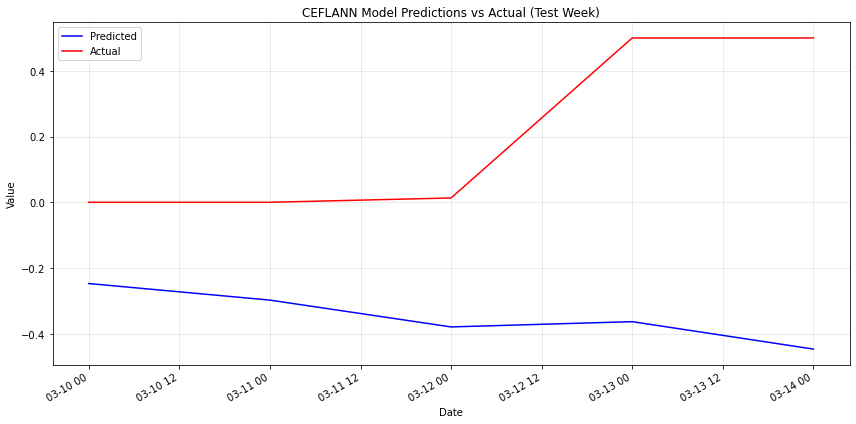

Test dates length: 5
Portfolio values length: 5


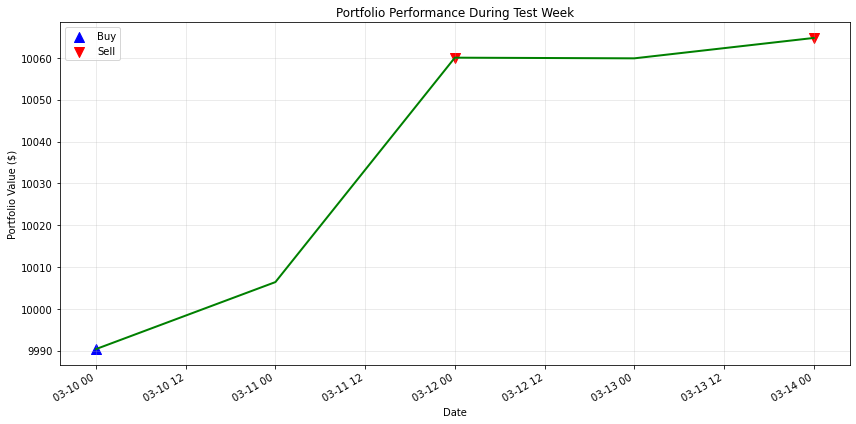


===== MODEL PERFORMANCE =====
MSE: 0.3890
RMSE: 0.6237
R²: -5.5956
MAE: 0.5494
Training Time: 0.0000 seconds

===== DAILY ORDERS =====
Day 1: Buy: 9 shares @ $106.97 ($962.73)
Day 2: Hold
Day 3: Sell: 8 shares @ $115.74 ($925.92)
Day 4: Hold
Day 5: Sell: 1 shares @ $121.67 ($121.67)
===== TRADING SUMMARY =====
Initial Portfolio: $10000.00
Final Portfolio: $10064.76
Profits/Losses: $64.76 (0.65%)
Total Transaction Fees: $20.10
Number of Buys: 1
Number of Sells: 2


In [30]:
def run_simulation_on_test_week(nvidia_data, week_index=-1):
    """
    Run a complete simulation on a test week
    
    Parameters:
        nvidia_data : Loaded NVIDIA data
        week_index : Index of the test week to use (-1 for most recent)
    
    Returns:
        results : Results of the pipeline run
    """
    # Get training data
    X_train = nvidia_data['X_train']
    y_train = nvidia_data['y_train']
    
    # Get test week data
    if week_index < 0 or week_index >= len(nvidia_data['test_weeks']):
        # Use the most recent week
        test_week = nvidia_data['test_weeks'][-1]
    else:
        test_week = nvidia_data['test_weeks'][week_index]
    
    X_test = test_week['X']
    y_test = test_week['y']
    test_dates = test_week['dates']
    
    # Extract prices from the test week
    if 'prices' in test_week and test_week['prices'] is not None:
        test_prices = test_week['prices']
    else:
        # If price data not available, use the latest close price
        test_prices = np.full(len(X_test), nvidia_data['latest_close'])
    
    # Run the trading pipeline
    results = run_trading_pipeline(
        X_train, y_train, X_test, y_test, test_prices, test_dates,
        expansion_order=5, regularization=0.01
    )
    
    # Visualize results
    plot_predictions_vs_actual(
        results['predictions'], y_test, test_dates,
        "CEFLANN Model Predictions vs Actual (Test Week)"
    )

    # Verify portfolio values length matches dates
    print(f"Test dates length: {len(test_dates)}")
    print(f"Portfolio values length: {len(results['simulation_results']['portfolio_values'])}")
    
    # Plot portfolio performance
    plot_portfolio_performance(
        results['simulation_results'], test_dates,
        "Portfolio Performance During Test Week"
    )
    
    display_trading_summary(results)
    
    return results

# Run simulation on the most recent test week
if nvidia_data['test_weeks']:
    print("Running simulation on the most recent test week...")
    results = run_simulation_on_test_week(nvidia_data)
else:
    print("No test weeks available. Please ensure the data is properly loaded.")